<a href="https://colab.research.google.com/github/larrygoyeau/bubble_segmentation_Mask_RCNN/blob/master/Mask_RCNN_automatic_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bubble segementation using Mask RCNN: inference model

In [0]:
#@title If you use google colab, first click on "ouvrir en mode brouillon" on the upper panel and run this block (click on this text and Ctrl+Entre). This will install the framwork. { run: "auto" }

import logging
logging.getLogger('tensorflow').disabled = True
%tensorflow_version 1.x

import os
os.system('git clone https://github.com/matterport/Mask_RCNN')
os.system('git clone https://github.com/larrygoyeau/bubble_segmentation_Mask_RCNN')
os.system('pip install -r /content/Mask_RCNN/requirements.txt')

import sys
sys.path.append('/content/Mask_RCNN')

import resource
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from skimage.measure import find_contours
from matplotlib.patches import Polygon
import requests

# Root directory of the project
ROOT_DIR = os.path.abspath("/content")

# Import Mask RCNN
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import visualize

%matplotlib inline 

# To increas the recursion limite
resource.setrlimit(resource.RLIMIT_STACK, [0x100000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x1000000)

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    #fif, ax = plt.subplots(rows, cols, figsize=(size*1.5, size*rows))
    return plt.subplots(rows, cols, figsize=(size*1.5, size*rows))

class InferenceConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    RPN_NMS_THRESHOLD = 0.55
    DETECTION_MAX_INSTANCES=350
    MAX_GT_INSTANCES=350
    DETECTION_MIN_CONFIDENCE=0

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

inference_config = InferenceConfig()

# Download trained weights from Releases if needed

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

MODEL_PATH = '/content/model.h5'

if not os.path.exists(MODEL_PATH):
    file_id = '1YcoGMfeX6FOjskI0o_L7MOWRhTYvUVlq'
    destination = MODEL_PATH
    download_file_from_google_drive(file_id, destination)
    print("Pretrained model downloaded!")


# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights
model.load_weights(MODEL_PATH, by_name=True)

def remove_bubble(mask,i,j,I,J,color):
  if mask[i,j]==color:
    mask[i,j]=0
    if 0<j:
      remove_bubble(mask,i,j-1,I,J,color)
    if i<I-1:
      remove_bubble(mask,i+1,j,I,J,color)
    if 0<i:
      remove_bubble(mask,i-1,j,I,J,color)
    if j<J-1:
      remove_bubble(mask,i,j+1,I,J,color)

def creat_mask(image_name,instance_mask,remove_bubbles_on_the_border,boxes):
  N=len(instance_mask[0][0])
  I=len(instance_mask)
  J=len(instance_mask[0])
  mask=np.zeros(instance_mask[...,0].shape)
  size_list=[]
  border=[]
  bubble=-1
  for n in range(N):
    color=random.randint(40, 255)
    size=0
    for i in range(I):
      for j in range(J):
        if instance_mask[i,j,n]:
          margin=3
          if i<margin or j<margin or i>I-margin or j>J-margin:
            if bubble!=n:
              border=border+[(i,j,n)]
              bubble=n
          mask[i,j]=color
          size=size+1
    size_list=size_list+[size]
  if remove_bubbles_on_the_border:
    k=0  
    for b in border:
      i,j,n=b
      remove_bubble(mask,i,j,I,J,mask[i,j])
      del size_list[n-k]
      instance_mask=np.delete(instance_mask, n-k, 2)
      boxes=np.delete(boxes, n-k, 0)
      k=k+1
  file = open(image_name[:-4]+".txt","w")
  file.write("Bubble index and its size\n")
  n=len(size_list)
  for i in range(n):
    file.write(str(i)+"  "+str(size_list[i])+"\n")
  file.close()
  return mask, size_list,instance_mask, boxes


def display_instances(ax,image_name,image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16),
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)

    cv2.imwrite('mask_plus_'+image_name[:-3]+'png', masked_image.astype(np.uint8))
    ax.imshow(masked_image.astype(np.uint8))
    ax.set_title("Number of detected bubbles "+str(len(masks[0][0])))
    ax.title.set_fontsize(25)

def show_and_save_segmentation(file_names):
  size_all_bubbles=[]
  mask_plus_image=[]
  n=len(file_names)
  fig, axarr = plt.subplots(n,1,figsize=(15, 9*n))
  i=0
  for image_name in file_names:
    path=os.path.join('/content', image_name)
    image=cv2.imread(path)
    path=path.replace(' ', '\ ')
    os.system('rm '+path)
    # Run detection
    results = model.detect([image], verbose=1)
    r = results[0]
    mask, size_list, instance_mask, boxes=creat_mask(image_name,r['masks'],remove_bubbles_on_the_border,r['rois'])
    cv2.imwrite('mask_of_'+image_name[:-3]+'png', mask)
    size_all_bubbles=size_all_bubbles+size_list
    if len(file_names)==1:
      ax=axarr
    else:
      ax=axarr[i]
    display_instances(ax,image_name,image, boxes, instance_mask , np.ones((len(instance_mask[0][0]))).astype(int), 
                            ['BG', ' '], np.zeros((len(instance_mask[0][0]))),show_bbox=False)
    i=i+1
    print("Number of detected bubbles "+str(len(instance_mask[0][0])))
  plt.show()
  return(size_all_bubbles)

TensorFlow 1.x selected.


Using TensorFlow backend.


Pretrained model downloaded!


In [0]:
#@title Do you want to remove the bubbles that are in contact with the outline of the images? { run: "auto" }

Select_the_answer_and_run_this_block = 'No' #@param ["Yes", "No"]

if Select_the_answer_and_run_this_block=='Yes':
  remove_bubbles_on_the_border=True
else:
  remove_bubbles_on_the_border=False

Now run the block below. Then click on “select fichiers” and select (several) images that you want to segment from your device. The segmented images are saved on the left panel 'fichier'. Click on 'actualliser' and the file will appear. These files are:


*   mask_plus_image_name.png $ $ $ $ for the segmentation plus the image
*   mask_of_image_name.png $ $ $ $ for the mask only
* image_name.txt $ $ $ $ for the description of each bubble detected on the image



 You can download them by right clicking on them and select 'telecharger'. If you get an error run once again or tell me.


Saving photo 11.png to photo 11.png
Saving photo 12.png to photo 12.png
Saving photo 13.png to photo 13.png
Processing 1 images
image                    shape: (128, 128, 3)         min:  119.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   -4.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Number of detected bubbles 76
Processing 1 images
image                    shape: (128, 128, 3)         min:  117.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   -6.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Number of detected bubbles 72
Processing 1 images
image   

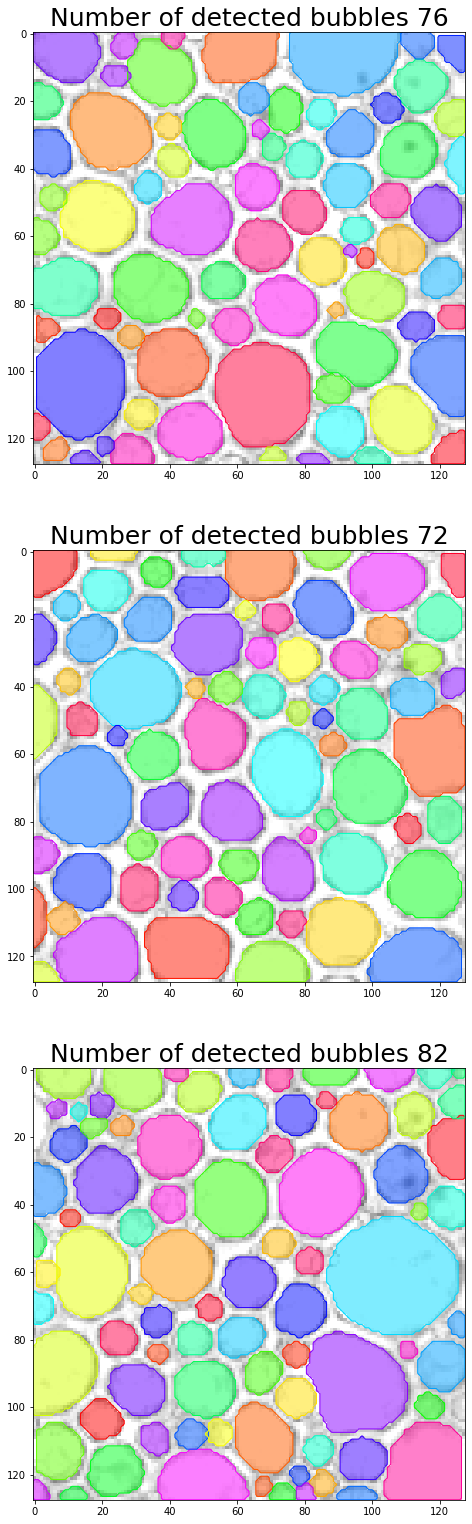

In [0]:
#@title Run this block { run: "auto" }

file_names = files.upload()

size_all_bubbles=show_and_save_segmentation(file_names)

For the distribution of the size of bubbles, run the block below. The historame is save as size_distribution.png

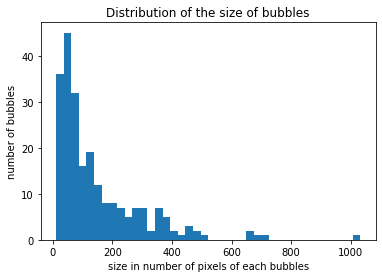

In [0]:
plt.hist(size_all_bubbles,bins = 40)
plt.xlabel('size in number of pixels of each bubbles')
plt.ylabel('number of bubbles')
plt.title('Distribution of the size of bubbles')
plt.savefig("/content/size_distribution.png")